In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
clean_tesla = pd.read_csv('../datasets/clean_tesla.csv')
clean_tweets = pd.read_csv('../datasets/clean_tweets.csv')
tw_tesla = pd.merge(clean_tweets, clean_tesla, how='inner', on='date')
tw_tesla = tw_tesla.sort_values(by='date', ascending=True)

In [63]:
sentimiento_diario = tw_tesla.groupby('date')['compound'].mean().reset_index()
sentimiento_diario.rename(columns={'compound': 'sentiment_avg'}, inplace=True)
tw_tesla = pd.merge(tw_tesla, sentimiento_diario, how='inner', on='date')

In [64]:
correlacion = tw_tesla['sentiment_avg'].corr(tw_tesla['Close'])
print(f"Correlación entre sentimiento promedio y precio de cierre: {correlacion:.4f}")

Correlación entre sentimiento promedio y precio de cierre: 0.0159


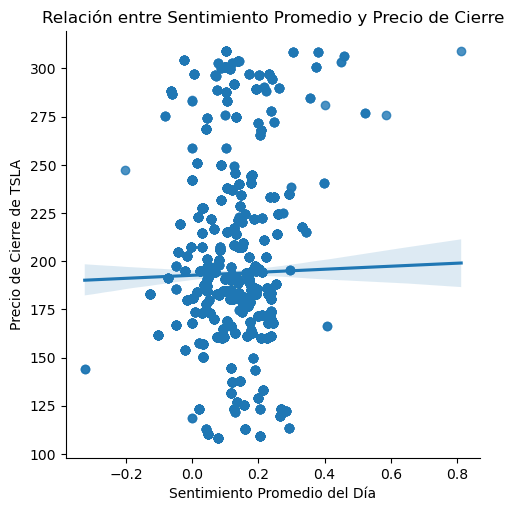

In [65]:
sns.lmplot(x='sentiment_avg', y='Close', data=tw_tesla)
plt.title("Relación entre Sentimiento Promedio y Precio de Cierre")
plt.xlabel("Sentimiento Promedio del Día")
plt.ylabel("Precio de Cierre de TSLA")
plt.show()

In [66]:
tw_tesla['sentiment_avg_lag1'] = tw_tesla['sentiment_avg'].shift(1)
correlacion_lag = tw_tesla['sentiment_avg_lag1'].corr(tw_tesla['Close'])
print(f"Correlación con 1 día de desfase: {correlacion_lag:.4f}")

Correlación con 1 día de desfase: 0.0162


In [67]:
tw_tesla['daily_change_pct'] = ((tw_tesla['Close'] - tw_tesla['Open']) / tw_tesla['Open']) * 100
tw_tesla['daily_change_usd'] = (tw_tesla['Close'] - tw_tesla['Open']) 

In [68]:
correlacion = tw_tesla['sentiment_avg'].corr(tw_tesla['daily_change_pct'])
print(f"Correlación entre sentimiento y cambio diario: {correlacion:.4f}")

Correlación entre sentimiento y cambio diario: 0.1532


In [40]:
tw_tesla['sentiment_avg_lag1'] = tw_tesla['sentiment_avg'].shift(1)
correlacion_lag = tw_tesla['sentiment_avg_lag1'].corr(tw_tesla['daily_change_pct'])
print(f"Correlación con 1 día de desfase: {correlacion_lag:.4f}")

Correlación con 1 día de desfase: 0.1412


In [69]:
tw_tesla['sentiment_avg_3d'] = tw_tesla['sentiment_avg'].rolling(3).mean()
correlacion_rolling = tw_tesla['sentiment_avg_3d'].corr(tw_tesla['daily_change_pct'])
print(f"Correlación con media móvil de 3 días: {correlacion_rolling:.4f}")

Correlación con media móvil de 3 días: 0.1493


In [70]:
extremos = tw_tesla[abs(tw_tesla['sentiment_avg']) > 0.5]
correlacion_extremos = extremos['sentiment_avg'].corr(extremos['daily_change_pct'])
print(f"Correlación en días con sentimiento extremo: {correlacion_extremos:.4f}")

Correlación en días con sentimiento extremo: 0.9285


In [71]:
tw_tesla_extremos = tw_tesla[tw_tesla['compound'].abs() > 0.5]
print(f"Tweets con sentimiento extremo: {len(tw_tesla_extremos)}")

Tweets con sentimiento extremo: 786


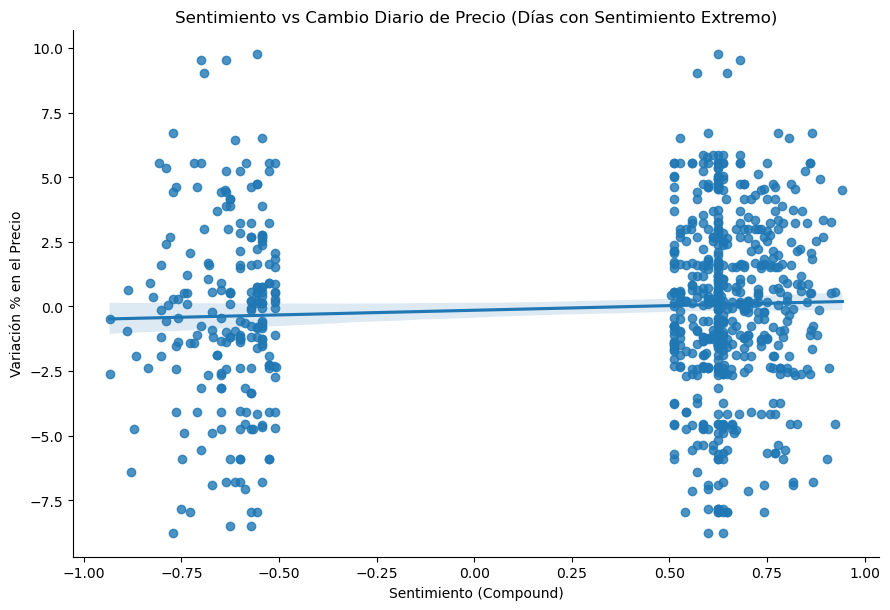

In [72]:
sns.lmplot(data=tw_tesla_extremos, x='compound', y='daily_change_pct', height=6, aspect=1.5)
plt.title("Sentimiento vs Cambio Diario de Precio (Días con Sentimiento Extremo)")
plt.xlabel("Sentimiento (Compound)")
plt.ylabel("Variación % en el Precio")
plt.show()

In [73]:
# Filtrar solo días extremos según el promedio diario
extremos_df = tw_tesla[tw_tesla['sentiment_avg'].abs() > 0.5]

# Agrupar por fecha y obtener una fila por día
extremos_por_dia = extremos_df.groupby('date').agg({
    'sentiment_avg': 'mean',
    'daily_change_pct': 'mean'
}).reset_index()


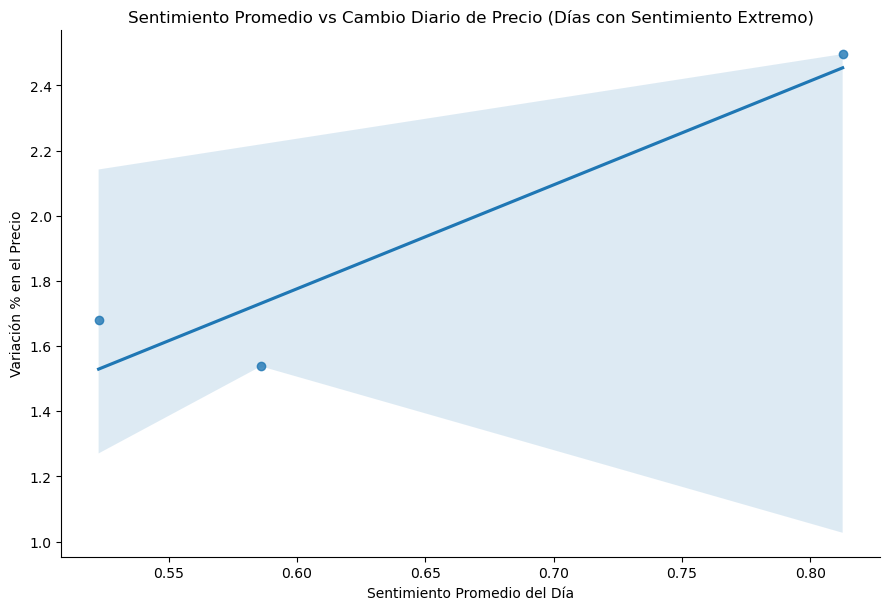

In [74]:
sns.lmplot(data=extremos_por_dia, x='sentiment_avg', y='daily_change_pct', height=6, aspect=1.5)
plt.title("Sentimiento Promedio vs Cambio Diario de Precio (Días con Sentimiento Extremo)")
plt.xlabel("Sentimiento Promedio del Día")
plt.ylabel("Variación % en el Precio")
plt.show()

In [75]:
correlacion_verificada = extremos_por_dia['sentiment_avg'].corr(extremos_por_dia['daily_change_pct'])
print(f"Correlación real entre sentimiento promedio y cambio diario (filtrado): {correlacion_verificada:.4f}")


Correlación real entre sentimiento promedio y cambio diario (filtrado): 0.9404


Los dias con sentimiento extremo, si bien muestran una correlacion mas alta, es una muestra demasiado pequeña para modelar a partir de esto.

In [76]:
tw_tesla['influencia_sentimental'] = tw_tesla['compound'] * (1 + tw_tesla['retweets'])
tw_tesla['influencia_sentimental_log'] = tw_tesla['compound'] * np.log1p(tw_tesla['retweets'])

Se empieza a analizar el sentimiento ponderado por la influencia (cantidad de retweets)

In [77]:
infl_diaria = tw_tesla.groupby('date')['influencia_sentimental_log'].sum().reset_index()
infl_diaria.rename(columns={'influencia_sentimental_log': 'sentimiento_amplificado'}, inplace=True)


In [78]:
precio_diario = tw_tesla.groupby('date')['daily_change_pct'].mean().reset_index()
df_comparacion = pd.merge(infl_diaria, precio_diario, on='date', how='inner')
correlacion_amplificado = df_comparacion['sentimiento_amplificado'].corr(df_comparacion['daily_change_pct'])
print(f"Correlación entre sentimiento amplificado y cambio diario: {correlacion_amplificado:.4f}")

Correlación entre sentimiento amplificado y cambio diario: 0.0783


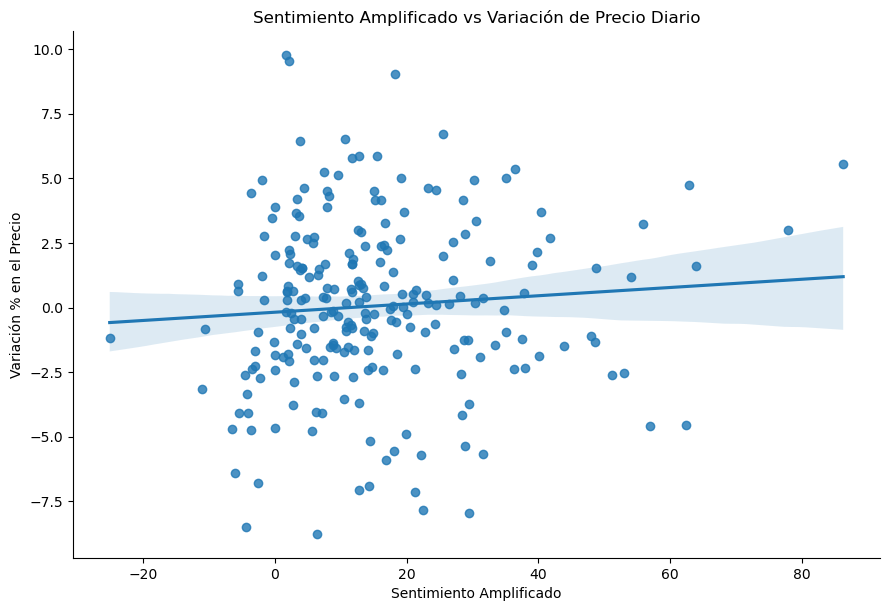

In [79]:
sns.lmplot(data=df_comparacion, x='sentimiento_amplificado', y='daily_change_pct', height=6, aspect=1.5)
plt.title("Sentimiento Amplificado vs Variación de Precio Diario")
plt.xlabel("Sentimiento Amplificado")
plt.ylabel("Variación % en el Precio")
plt.show()

In [80]:
tw_tesla['influencia_total'] = tw_tesla['compound'] * (
    np.log1p(tw_tesla['retweets'] + tw_tesla['favorites']) * np.log1p(tw_tesla['user_followers'])
)


In [81]:
infl_diaria2 = tw_tesla.groupby('date')['influencia_total'].sum().reset_index()
infl_diaria2.rename(columns={'influencia_total': 'sentimiento_amplificado_total'}, inplace=True)

In [84]:
df_comparacion2 = pd.merge(infl_diaria2, precio_diario, on='date', how='inner')
correlacion_amplificado2 = df_comparacion2['sentimiento_amplificado_total'].corr(df_comparacion2['daily_change_pct'])
print(f"Correlación entre sentimiento amplificado total y cambio diario: {correlacion_amplificado2:.4f}")

Correlación entre sentimiento amplificado total y cambio diario: 0.0731


Se busca la correlacion entre una nueva feature que pondera los seguidores, favoritos y retweets con la variacion del mercado, se alcanza uan correlacion del 7%

Correlación entre infl_rt y cambio diario: 0.0783
Correlación entre infl_fav y cambio diario: 0.0731
Correlación entre infl_followers y cambio diario: 0.0665
Correlación entre infl_total y cambio diario: 0.0731


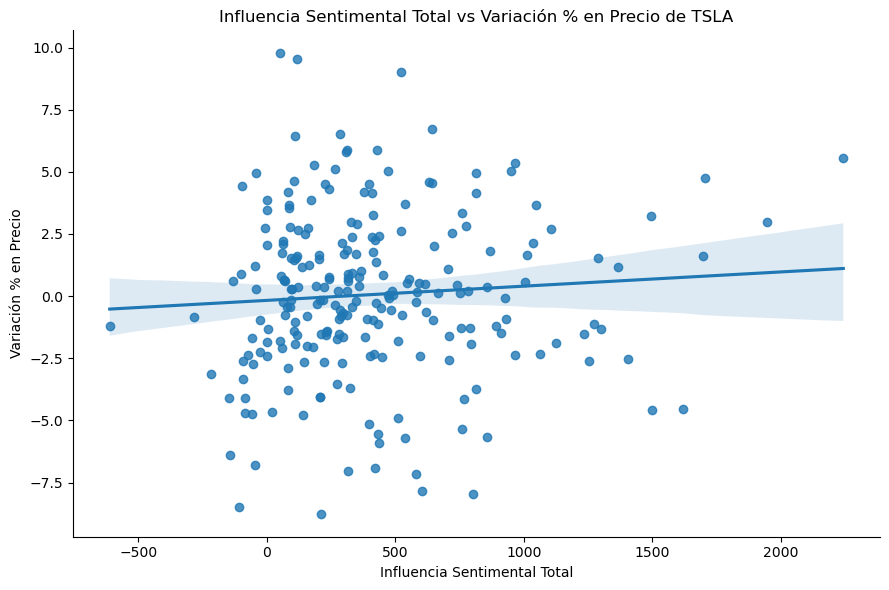

In [85]:


# Asegura que no hay NaNs
tw_tesla.fillna(0, inplace=True)

# Versión 1: retweets
tw_tesla['infl_rt'] = tw_tesla['compound'] * np.log1p(tw_tesla['retweets'])

# Versión 2: favorites
tw_tesla['infl_fav'] = tw_tesla['compound'] * np.log1p(tw_tesla['favorites'])

# Versión 3: followers (potencial de visibilidad)
tw_tesla['infl_followers'] = tw_tesla['compound'] * np.log1p(tw_tesla['user_followers'])

# Versión 4: combinación total
tw_tesla['infl_total'] = tw_tesla['compound'] * (
    np.log1p(tw_tesla['retweets'] + tw_tesla['favorites']) * np.log1p(tw_tesla['user_followers'])
)

# 2. Agregación diaria
# Agrupamos por fecha y sumamos las influencias

influencias = tw_tesla.groupby('date')[['infl_rt', 'infl_fav', 'infl_followers', 'infl_total']].sum().reset_index()
precios = tw_tesla.groupby('date')['daily_change_pct'].mean().reset_index()


# 3. Unión final


df_final = pd.merge(influencias, precios, on='date', how='inner')


# 4. Cálculo de correlaciones


for col in ['infl_rt', 'infl_fav', 'infl_followers', 'infl_total']:
    corr = df_final[col].corr(df_final['daily_change_pct'])
    print(f"Correlación entre {col} y cambio diario: {corr:.4f}")


# 5. Gráfico de influencia total


sns.lmplot(data=df_final, x='infl_total', y='daily_change_pct', height=6, aspect=1.5)
plt.title("Influencia Sentimental Total vs Variación % en Precio de TSLA")
plt.xlabel("Influencia Sentimental Total")
plt.ylabel("Variación % en Precio")
plt.tight_layout()
plt.show()


Posteriormente, se busca ponderar las variables principales del tweet como: retweets, favoritos, seguidores y una ponderación completa dentro del mismo codigo para que sea mas comparable. Se concluye que se alcanza la mayor correlación (7.83%) poderando el sentimiento y la cantidad de retweets.

In [86]:
tw_tesla['objetivo'] = (tw_tesla['daily_change_pct'] > 0).astype(int)

In [87]:
print(tw_tesla.columns)

Index(['date', 'hour', 'month', 'day', 'texto_limpio', 'text',
       'user_followers', 'user_friends', 'retweets', 'favorites',
       'Sentiment Category', 'compound', 'Volume', 'Open', 'Close',
       'sentiment_avg', 'sentiment_avg_lag1', 'daily_change_pct',
       'daily_change_usd', 'sentiment_avg_3d', 'influencia_sentimental',
       'influencia_sentimental_log', 'influencia_total', 'infl_rt', 'infl_fav',
       'infl_followers', 'infl_total', 'objetivo'],
      dtype='object')


In [88]:
features = [
    'date','objetivo','user_followers', 'retweets', 'favorites', 'compound',
    'sentiment_avg', 'sentiment_avg_lag1', 'sentiment_avg_3d',
    'Volume',  # volumen de trading (mercado real)
    'Open',    # precio al inicio del día
    'infl_rt', 'infl_fav', 'infl_followers', 'infl_total'
]


In [89]:
df_model = tw_tesla[features].copy()



In [92]:
objetivo_suma = df_model['objetivo'].value_counts()
print(objetivo_suma)

objetivo
1    2042
0    2011
Name: count, dtype: int64


In [ ]:
df_model.to_csv('../datasets/df_model.csv', index=False)
objetivo.to_csv('../datasets/objetivo.csv', index=False)

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                4053 non-null   object 
 1   objetivo            4053 non-null   int32  
 2   user_followers      4053 non-null   int64  
 3   retweets            4053 non-null   int64  
 4   favorites           4053 non-null   int64  
 5   compound            4053 non-null   float64
 6   sentiment_avg       4053 non-null   float64
 7   sentiment_avg_lag1  4053 non-null   float64
 8   sentiment_avg_3d    4053 non-null   float64
 9   Volume              4053 non-null   int64  
 10  Open                4053 non-null   float64
 11  infl_rt             4053 non-null   float64
 12  infl_fav            4053 non-null   float64
 13  infl_followers      4053 non-null   float64
 14  infl_total          4053 non-null   float64
dtypes: float64(9), int32(1), int64(4), object(1)
memory usa

In [ ]:
print(df_model['objetivo'].value_counts())

objetivo
1    2042
0    2011
Name: count, dtype: int64


In [95]:
print(df_model['date'])

0       2022-07-05
1       2022-07-05
2       2022-07-05
3       2022-07-05
4       2022-07-05
           ...    
4048    2023-06-12
4049    2023-06-12
4050    2023-06-13
4051    2023-06-13
4052    2023-06-13
Name: date, Length: 4053, dtype: object


In [96]:
print(df_model['date']).unique()

0       2022-07-05
1       2022-07-05
2       2022-07-05
3       2022-07-05
4       2022-07-05
           ...    
4048    2023-06-12
4049    2023-06-12
4050    2023-06-13
4051    2023-06-13
4052    2023-06-13
Name: date, Length: 4053, dtype: object


AttributeError: 'NoneType' object has no attribute 'unique'